In [2]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import cPickle as pkl
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [5]:
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'

sess_list = ['JC097_20190621','JC085_20190624','JC097_20190628','JC097_20190704','JC085_20190712']
area = 'V1'

# sess_list = ['JC080_20190619','JC091_20190621','JC091_20190628','JC097_20190702','JC091_20190703','JC085_20190704','JC097_20190708']
# area = 'LM'

# sess_list = ['JC091_20190625','JC091_20190701','JC091_20190705']
# area = 'LI'

response_type = 'norm_df'

filter_crit = 'zscore'
filter_thresh = 1

#define paths
aggregate_file_dir = os.path.join(aggregate_root,area,'files',)
fig_out_dir = os.path.join(aggregate_root,area,'figures')

if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

In [6]:
#put things into pandas df for plotting
sess_dfs = []
sess_norm_dfs = []
animalids = []
sess_count = []
neuron_count = np.empty((10,10))
neuron_frac = np.empty((10,10))

ylabel = 'Normalized Response'

for sess_idx, sess in enumerate(sess_list):
#sess_idx = 0
#sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]
    
    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)
        
    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1
    
    data_array_fn = '%s_filtered_%s_traces_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')
    
    if sess_idx == 0:
        frames_tsec = np.array(data_grp.attrs['frames_tsec'])

    
    curr_slice = 'Slice01'#hard-code planar data for now
    
    num_active_rois = int(np.array(data_grp['/'.join([curr_slice,'n_active_rois'])]))
    frac_active_rois = float(np.array(data_grp['/'.join([curr_slice,'frac_active_rois'])]))
    
    neuron_count[animalids.index(animalid),sess_count[animalids.index(animalid)]-1] = num_active_rois
    neuron_frac[animalids.index(animalid),sess_count[animalids.index(animalid)]-1] = frac_active_rois
    
    sess_trace = np.array(data_grp['/'.join([curr_slice, 'filtered_trace_per_cond_mean_across_neurons'])])
    sess_se = np.array(data_grp['/'.join([curr_slice, 'filtered_trace_per_cond_se_across_neurons'])])
    #normalize
    sess_trace_norm = sess_trace/np.nanmax(sess_trace.flatten())
    
    #store in array
    if sess_idx == 0:
        trace_array = sess_trace
        trace_array_norm = sess_trace_norm
    else:
        #pad array with nan if necessary
        if sess_trace.shape[0]<trace_array.shape[0]:
            sess_trace = np.pad(sess_trace,((0,1),(0,0)),'constant',constant_values = (0,np.nan))
            sess_se = np.pad(sess_se,((0,1),(0,0)),'constant',constant_values = (0,np.nan))
        
            sess_trace_norm = np.pad(sess_trace_norm,((0,1),(0,0)),'constant',constant_values = (0,np.nan))
        trace_array = np.dstack((trace_array,sess_trace))
        trace_array_norm = np.dstack((trace_array_norm,sess_trace_norm))
        
        
    for cond_count in range(sess_trace.shape[1]):
        stim_cond = cond_count
        mean_trace = sess_trace[:,cond_count]
        sem_trace = sess_se[:,cond_count]
        cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                            'animalid': animalid,
                             'session': sess_count[animalids.index(animalid)],
                              'tsec': frames_tsec,
                             'sem': sem_trace,
                             'fill_minus': mean_trace - sem_trace,
                            'fill_plus': mean_trace + sem_trace,
                            'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                           })

        sess_dfs.append(cdf)

    
#     for cond_count in range(sess_trace.shape[1]):
#         stim_cond = cond_count
#         mean_trace = sess_trace_norm[:,cond_count]
#         sem_trace = sess_se[:,cond_count]
#         nreps = num_active_rois
#         freps = frac_active_rois
#         cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
#                             'tsec': frames_tsec,
#                             'sem': sess_se,
#                            'fill_minus': mean_trace - sem_trace,
#                             'fill_plus': mean_trace + sem_trace,
# #                             'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
#                            })

#         sess_norm_dfs.append(cdf)
#     sess_norm_dfs = pd.concat(sess_norm_dfs, axis=0)
    
    data_grp.close()
sess_dfs = pd.concat(sess_dfs, axis=0)

In [7]:
#make figure
trace_labels = ['Original','Sf-Match','Corr-Match']
fig_fn = 'avg_trace_per_session_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)


p = sns.FacetGrid(sess_dfs, row = 'animalid',col = 'session', hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)
pl.subplots_adjust(wspace=0.1, hspace=0.8, top=0.85, bottom=0.1, left=0.1)

axes = p.axes
ymin,ymax = axes[0][0].get_ylim()
xmin,xmax = axes[0][0].get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding
for ri in range(p.axes.shape[0]):
    for ci in range(p.axes.shape[1]):
            #print ri, ci
            p.axes[ri,ci].add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
            p.axes[ri,ci].text(-0.999, ymax+(ymax*0), 'n=%i, f = %.04f' % (neuron_count[ri,ci],neuron_frac[ri,ci]), fontsize=10)
            p.axes[ri,ci].axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')

            if ri == 0:
              #  p.axes[ri].yaxis.set_major_locator(pl.MaxNLocator(2))
                p.axes[ri,ci].set_xticks(())
                sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.axes[ri,ci])
                p.axes[ri,ci].set_xlabel('time (s)', fontsize=8)
                p.axes[ri,ci].set_ylabel('%s' % ylabel, fontsize=8)
            else:
                sns.despine(trim=True, offset=0, bottom=True, left=True, ax=p.axes[ri,ci])
                p.axes[ri,ci].tick_params(
                                        axis='both',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom='off',      # ticks along the bottom edge are off
                                        left='off',
                                        top='off',         # ticks along the top edge are off
                                        labelbottom='off',
                                        labelleft='off') # labels along the bottom edge are off)
                p.axes[ri,ci].set_xlabel('')
                p.axes[ri,ci].set_ylabel('')
pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)
p.savefig(fig_file_path)
plt.close()

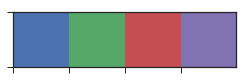

In [270]:
sns.set_palette('deep',4)
sns.palplot(sns.color_palette())


In [8]:
#put things into pandas df for plotting


ylabel = 'Normalized Response'

for sess_idx, sess in enumerate(sess_list):
    print(sess)
#     sess_idx = 0
#     sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]

    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1

    data_array_fn = '%s_filtered_%s_traces_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    if sess_idx == 0:
        frames_tsec = np.array(data_grp.attrs['frames_tsec'])


    curr_slice = 'Slice01'#hard-code planar data for now

    sess_trace = np.array(data_grp['/'.join([curr_slice, 'filtered_trace_per_cond_per_neuron_mean_across_images'])])

    #store in array
    if sess_idx == 0:
        trace_array = sess_trace
    else:
        #pad array with nan if necessary
        if sess_trace.shape[0]<trace_array.shape[0]:
            sess_trace = np.pad(sess_trace,((0,1),(0,0),(0,0)),'constant',constant_values = (0,np.nan))

        trace_array = np.dstack((trace_array,sess_trace))


data_grp.close()


JC097_20190621
JC085_20190624
JC097_20190628
JC097_20190704
JC085_20190712


In [9]:
#get some activity stats
n_total_cells = trace_array.shape[2]
n_active_cells = np.sum(np.logical_not(np.isnan(trace_array[0,0,:])))
frac_active_cells = n_active_cells/float(n_total_cells)

In [10]:
trace_array_mean = np.nanmean(trace_array,2)
trace_array_se = np.nanstd(trace_array,2)/np.sqrt(n_active_cells)

In [11]:
#put things into pandas df for plotting
conddfs = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cond_count in range(trace_array_mean.shape[1]):
    stim_cond = cond_count
    mean_trace = trace_array_mean[:,cond_count]
    sem_trace = trace_array_se[:,cond_count]
    nreps = n_active_cells
    cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    conddfs.append(cdf)
conddfs = pd.concat(conddfs, axis=0)

In [12]:
fig_fn = 'avg_trace_across_all_active_cells_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(conddfs, hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)


axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding

        #print ri, ci
p.ax.add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
p.ax.text(-0.999, ymax+(ymax*0), 'n=%i, f=%.04f' % (n_active_cells,frac_active_cells), fontsize=10)
p.ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')


#p.ax.set_xticks(())
#sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.ax)
p.ax.set_xlabel('time (s)', fontsize=12)
p.ax.set_ylabel('%s' % ylabel, fontsize=12)


pl.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=10)


p.savefig(fig_file_path)
plt.close()

In [ ]:
# 

In [ ]:
#----Junk Code below here------